# Needed for the FEC
- time (also time of bounce if possible)
- shock radius 
- size of the neutrinosphere 
- gain radius
- Mass accretion rate averaged into gain region
- total net heating
- kappa_nue and kappa_anue
- lum_nue and lum_anue
- turbulent dissipation turbulent dissipation. Ek=u'^3/L*Mg where u' is the turbulent velocity, L is the largest eddy size (I usually take this to be a size of the gain region) and Mg is the mass in the gain region. 
- Raynolds stress which is u'^2 averaged in the gain region. 


In [73]:
#Standard imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yt                                                                                                                                                    
from yt import derived_field
import astropy.constants as cn
import astropy.units as u
import h5py
from scipy.interpolate import RegularGridInterpolator as rgi
from scipy.interpolate import interp1d
import itertools
import time
#add more as needed
#import h5py
#derived fields:
@derived_field(name='mycostheta',sampling_type='cell')
def _mycostheta(field,data):
    return data['z']/np.sqrt(data['r']**2+data['z']**2)

@derived_field(name='mysintheta',sampling_type='cell')
def _mysintheta(field,data):
    return data['r']/np.sqrt(data['r']**2+data['z']**2)

# @derived_field(name='myphi',sampling_type='cell')
# def _myphi(field,data):
#     return np.asin(data['z']/np.sqrt(data['r']**2+data['z']**2))

#Checked and this works out to what it should be, using the fact that sin(pi/2-x) = cos(x)
@derived_field(name='vrad',units='cm/s',sampling_type='cell')
def _vrad(field,data):
    return data['vely']*data['mycostheta']+data['velx']*data['mysintheta']


@derived_field(name='vphi',units='cm/s',sampling_type='cell')
def _vphi(field,data):
    return data['vely']*data['mysintheta']-data['velx']*data['mycostheta']

@derived_field(name='spherical_radius',units='cm',sampling_type='cell')
def _spherical_radius(field,data):
    return np.sqrt(data['z']**2+data['r']**2)

In [2]:
#Code units we might need
NULIB_ENERGY_GF = 1.60217733e-6*5.59424238e-55
NULIB_MEV_TO_ERG = 1.60217733e-6
NULIB_HBARCMEVCM = 1.97326966e-11
CLIGHT = 29979245800.0
NULIB_EMISSIVITY_GF = 5.59424238e-55/((6.77140812e-06**3)*2.03001708e+05)
NULIB_OPACITY_GF = 1.0/6.77140812e-06
kelvin_to_MeV = 1.0/1.1604447522806e10
PI = np.pi

BB_NORM =CLIGHT *(NULIB_MEV_TO_ERG/(2.0*PI*NULIB_HBARCMEVCM)**3)
BB_NORM = BB_NORM*NULIB_EMISSIVITY_GF/NULIB_OPACITY_GF/NULIB_ENERGY_GF 
BBINT_NORM =CLIGHT *(NULIB_MEV_TO_ERG/(2.0*PI*NULIB_HBARCMEVCM)**3)
BBINT_NORM= BBINT_NORM*NULIB_EMISSIVITY_GF/NULIB_OPACITY_GF 

In [3]:
#Helper functions to deal with nulibtables
def read_nulib_table(fil: str) -> dict:

    table = h5py.File(fil, 'r') 
  
    nulib_temp = np.asarray(table["temp_points"])
    nulib_rho = np.asarray(table["rho_points"])
    nulib_ye = np.asarray(table["ye_points"])
    scatter = np.asarray(table["scattering_opacity"])
    abso = np.asarray(table["absorption_opacity"])
    energy_bins = np.array(table["neutrino_energies"]) 
    emiss = np.asarray(table['emissivities'])
    bw = np.asarray(table['bin_widths'])

    nulib_table = {"energy" : energy_bins, "rho" : nulib_rho, "temp" : nulib_temp, "ye" : nulib_ye,
                   "scatter" : scatter, "absorption" : abso, "emissivities" : emiss, 'bin_width' : bw }

    return nulib_table

def read_eos_table(fil: str) -> dict:
    eosfile = h5py.File(fil, 'r')
    eos_mu = np.asarray(eosfile["mu_e"]) - np.asarray(eosfile["mu_n"]) + np.asarray(eosfile["mu_p"])
    eos_logden = np.asarray(eosfile["logrho"])
    eos_logtemp = np.asarray(eosfile["logtemp"])
    eos_ye = np.asarray(eosfile["ye"])

    eos_table = {"mu" : eos_mu, "log_rho" : eos_logden, "log_temp" : eos_logtemp, "ye" : eos_ye}
    return eos_table

def integrate_table_v4(nulib_table: dict,eos_table: dict) -> np.ndarray:
    mfac = np.array([1.0,-1.0,0.0])
    fac = np.array([1.0,1.0,4.0])
    table = np.zeros([3,4,len(nulib_table["rho"]),len(nulib_table["temp"]),len(nulib_table["ye"])])
    points = (eos_table["ye"],eos_table["log_temp"],eos_table["log_rho"])
    energy = np.array(nulib_table["energy"])
    
    xv,yv,zv = np.meshgrid(nulib_table["ye"],np.log10(nulib_table["temp"]),np.log10(nulib_table["rho"]),indexing="ij")

    m1 = interpolate.interpn(points, eos_table["mu"], (xv,yv,zv))

    for n in range(0,3):
        print(n)
        
        eta = (nulib_table["energy"][:,None,None,None]-mfac[n]*m1)/nulib_table["temp"][None,None,:,None]
        bb = fac[n]/(1.0+np.exp(eta))*(nulib_table["energy"][:,None,None,None])**3
        bb_int = np.trapz(bb,x=nulib_table["energy"],axis=0)
        
        absorption = np.zeros([*nulib_table["absorption"][:,n,:,:,:].shape])
        absorption[:,:,:,:] = bb[:,:,:,:]*nulib_table["absorption"][:,n,:,:,:]
        absorption_int = np.trapz(absorption,x=nulib_table["energy"],axis=0)

        table[n,0,:,:,:] = absorption_int[:,:,:].T
        table[n,1,:,:,:] = np.divide(absorption_int[:,:,:],bb_int[:,:,:],
                                           out=np.zeros_like(absorption_int[:,:,:]), where=bb_int[:,:,:]!=0).T
    
       
        #Emis for N field
        emiss = np.zeros([*absorption.shape])
        for i in range(len(nulib_table["energy"])):
            emiss[i,:,:,:] = absorption[i,:,:,:]/nulib_table["energy"][i]
        emiss_int = np.trapz(emiss,x=nulib_table["energy"],axis=0) 
 
        table[n,3,:,:,:] = emiss_int[:,:,:].T


        #Scattering for E field
        scatter  = np.zeros([*nulib_table["absorption"][:,n,:,:,:].shape])
        scatter[:,:,:,:] = bb[:,:,:,:]*nulib_table["scatter"][:,n,:,:,:]
                        
        scatter_int = np.trapz(scatter,x=nulib_table["energy"],axis=0) 
        table[n,2,:,:,:] = np.divide(scatter_int[:,:,:],bb_int[:,:,:],
                                           out=np.zeros_like(scatter_int[:,:,:]), where=bb_int[:,:,:]!=0).T

    return table


In [4]:
def save_fec_as_hf5f(table: dict, table_name: str = "table.h5") -> None:
    hf = h5py.File(table_name, 'w')
    for key in table.keys():
        hf.create_dataset(key, data=table[key])
    hf.close()

In [74]:
def fec(eosnr: int, datfile: str,log_file: str, plot_files: list) -> dict:
    """
    eosnr mapping [0,1,2] -> [0.55, 0.75, 0.95]
    """
    dat_file = read_datfile(datfile)
    fec_data = {}
    #TODO: Interpolate
    fec_data['time'] = get_time(dat_file)
    fec_data['bounce_time'] = get_bounce_time(eosnr)
    fec_data['shock_radius'] = get_shock_radius(dat_file)
    fec_data['lum_nue'] = get_lum_nue(dat_file)
    fec_data['lum_anue'] = get_lum_anue(dat_file)
    fec_data['heating'] = get_heating(dat_file)
    
    plt_times = []
    f_enclosed_mass = []
    fec_data['mass_gainlayer'] = []
    
    fec_data['kappa_nue'] = []#get_kappa_nue(eosnr, plt_file) #done
    fec_data['kappa_anue'] = []# get_kappa_anue(eosnr, plt_file) #done

    fec_data['raynolds_stress'] = [] #get_raynolds_stress_spherical_coorinates_Murphy13(plt_file) #done
    fec_data['r'] = []
    PNS_radius = get_average_PNS_radius(dat_file)
    fPNS_radius = interp1d(fec_data['time'], PNS_radius)
    
    total_files = len(plot_files)
    update_interval = max(1, total_files // 20)
    start_time = time.time()
    
    for index,plt_file in enumerate(plot_files):
        ds = yt.load(plt_file)
        plt_times.append(ds.current_time.value)
        #need to decide how to calculate these
        #Maybe we should open once and send that to the
        #functions instead of sending the name and using yt open
        #inside of all functions
        
        rkappa_nue, kappa_nue  = get_kappa_nue(plt_file,eosnr)
        rkappa_anue, kappa_anue  = get_kappa_anue(plt_file,eosnr)
        rstress,stress = get_raynolds_stress_spherical_coorinates_Murphy13(plt_file)

        #Make sure that the 
        fec_data['r'].append(rstress)
        fec_data['raynolds_stress'].append(stress) #done
        fec_data['kappa_nue'].append(np.interp(rstress,rkappa_nue,kappa_nue)) #done
        fec_data['kappa_anue'].append(np.interp(rstress,rkappa_anue,kappa_anue)) #done
        
        #fec_data['turbulent_dissipation'] = get_turbulent_dissipation(plt_file) # "done"
        #Eq. 22 say that we can use ek = (R_rr**3/2 / length_scale) 
        #https://arxiv.org/pdf/1706.00072.pdf
        rsh = np.interp(plt_times[-1], fec_data['time'], fec_data['shock_radius'])
        rg = get_gain_radius(eosnr,plt_times[-1])
        rPNS = fPNS_radius(plt_times[-1])
        if rg < rPNS:
            rg = rPNS
        encmass_func = get_enclosed_mass(plt_file)
        if (plt_times[-1] > fec_data['bounce_time']) & (rsh >= rg):
            fec_data['mass_gainlayer'].append(encmass_func(rsh)-encmass_func(rg))
        else:
            fec_data['mass_gainlayer'].append(0)


        # Time and progress bar update
        if index % update_interval == 0 or index == total_files - 1:
            current_time = time.time()
            elapsed_time = current_time - start_time
            progress = (index + 1) / total_files
            bar_length = 20  # Length of the progress bar
            num_hashes = int(bar_length * progress)

        # Estimate time remaining
        if index > 0:
            time_per_unit = elapsed_time / index
            remaining_time = time_per_unit * (total_files - index - 1)
            remaining_minutes = int(remaining_time // 60)
            remaining_seconds = int(remaining_time % 60)
            time_str = f"{remaining_minutes}m {remaining_seconds}s left"
        else:
            time_str = "Calculating time..."

        # Update progress bar
        bar = '[' + '#' * num_hashes + ' ' * (bar_length - num_hashes) + ']'
        print(f"\rProgress: {bar} {progress * 100:.2f}% - {time_str}", end='')          
    print("\nLoop completed!")

    
    
    fec_data['shock_radius'] = np.interp(plt_times, fec_data['time'], fec_data['shock_radius'])
    fec_data['lum_nue'] = np.interp(plt_times, fec_data['time'], fec_data['lum_nue'])
    fec_data['lum_anue'] = np.interp(plt_times, fec_data['time'], fec_data['lum_anue'])
    fec_data['heating'] = np.interp(plt_times, fec_data['time'], fec_data['heating'])
    fec_data['gain_radius'] = get_gain_radius(eosnr,plt_times) #done
    fec_data['mass_accretion'] = get_mass_accretion(eosnr,plt_times) #done
    #fec_data['mass_gainlayer'] = f_enclosed_mass #done
    fec_data['time'] = plt_times
    print("\nFEC completed!")
    return fec_data

In [10]:
import h5py

def add_to_hdf5(file_number, data_dict, hdf5_filename="output.hdf5"):
    """
    Add data to an HDF5 file, creating groups and datasets based on the provided dictionary.

    :param file_number: The number that will be used as the group name.
    :param data_dict: A dictionary where each key-value pair will be saved as a dataset.
    :param hdf5_filename: The name of the HDF5 file to write to.
    """
    group_name = str(file_number).zfill(4)  # Ensures the file number is in the format 0001, 0002, etc.

    with h5py.File(hdf5_filename, 'a') as hdf:  # 'a' mode will create the file if it doesn't exist.
        group = hdf.require_group(group_name)  # Creates the group if it doesn't exist.

        for key, value in data_dict.items():
            # Create or overwrite the dataset within the group.
            group.create_dataset(key, data=value, compression="gzip")

    # Example usage:
    #data = {'dataset1': [1, 2, 3], 'dataset2': [4, 5, 6]}
    #add_to_hdf5(1, data)
    return None


In [11]:
def radial_integrals_for_all_groups(hdf5_filename):
    """
    Perform radial integrals of quantities in an HDF5 file for all groups.

    :param hdf5_filename: The name of the HDF5 file.
    :return: A dictionary of ndarrays with integrals for each quantity.
    """
    integrals = {}

    with h5py.File(hdf5_filename, 'r') as hdf:
        for group_name in hdf:
            group = hdf[group_name]
            datanames= ['kappa_nue', 'kappa_anue', 'mass_accretion', 'raynolds_stress']
            # Convert HDF5 datasets to NumPy arrays
            radius = np.array(group['radius'])
            shock_radius = group['shock_radius'][()]
            pns_radius = group['pns_radius'][()]
            gain_radius = group['gain_radius'][()]
            quantities = {k: np.array(group[k]) for k in datanames}

            # Compute the volume element
            dV = 2 * np.pi * radius**2

            # Initialize integrals for this group
            group_integrals = {key: [] for key in quantities}

            for key, quantity in quantities.items():
                # Select the range for integration
                range_pns_to_shock = (radius >= pns_radius) & (radius <= shock_radius)
                range_gain_to_shock = (radius >= gain_radius) & (radius <= shock_radius)

                # Integrate using the trapezoidal rule
                integral_pns_to_shock = np.trapz(quantity[range_pns_to_shock] * dV[range_pns_to_shock],
                                                 radius[range_pns_to_shock])
                integral_gain_to_shock = np.trapz(quantity[range_gain_to_shock] * dV[range_gain_to_shock], 
                                                  radius[range_gain_to_shock])

                # Store integrals
                group_integrals[key].append(integral_pns_to_shock)
                group_integrals[key].append(integral_gain_to_shock)

            # Add group integrals to overall integrals
            for key in group_integrals:
                if key in integrals:
                    integrals[key].append(group_integrals[key])
                else:
                    integrals[key] = [group_integrals[key]]

    # Convert lists to numpy arrays
    for key in integrals:
        integrals[key] = np.array(integrals[key])

    return integrals




In [12]:
def eosnr_to_eos(eosnr:int):
    eoslist = ['0.55', '0.75', '0.95']
    return eoslist[eosnr]

def get_outputbase(eosnr:int):
    eos = eosnr_to_eos(eosnr)
    return '/proj/astro_extreme/olivera/EOS_GWs/simulations_oliver/s20_HR_{}/output/s20_{}_hdf5_plt_cnt_'.format(eos, eos)

def get_pltrange(eosnr:int):
    if eosnr == 0:
        return [320, 1336]
    if eosnr == 1:
        return [320, 1299]    
    if eosnr == 2:
        return [320, 1175]  

In [ ]:
def read_hdf5_fec(file_name):
    """
    Reads data from an HDF5 file and returns it as a dictionary.
    
    Dataset Descriptions:
    - bounce_time: Time of core bounce.
    - gain_radius: Gain radius, when we can define it, if not the PNS radius 
                   Only an issue at early times 
    - heating: Heating in the gain layer.
    - kappa_anue, kappa_nue: Opacity values for electron anti-neutrinos and electron neutrinos.
    - lum_anue, lum_nue: Luminosity for anti-neutrinos and neutrinos.
    - mass_accretion: Mass accretion.
    - mass_gainlayer: Mass in the gain layer.
    - r: Radial grid at each timestep.
    - raynolds_stress: Reynolds stress: (r,r),(phi,phi),(r,phi),(phi,r).
    - shock_radius: Average radius of the shock.
    - time: Timestamps or time steps for the data.
    
    Some of the data is given as a function of time and radius,
    the radial coordinates at time-step i is given in r[i,:].
    """
    data = {}
    with h5py.File(file_name, 'r') as file:
        # List all groups
        print("Keys: %s" % file.keys())
        groups = list(file.keys())

        # Get the data
        for group in groups:
            print(f"Reading data for {group}")
            data[group] = file[group][()]

    return data

# Usage
file_name = 'FEC_s20_EOS095_full.h5'
data = read_hdf5(file_name)


In [13]:
#Group all the simple ones
def read_datfile(datfile,iskip=10):
    with open(dat_file) as f_in:
        dat = np.genfromtxt(itertools.islice(f_in, 0, None, iskip), dtype=float)
    return dat

def get_time(dat_file):
    return dat_file[:,0]

def get_lum_nue(dat_file):
    return dat_file[:,33] # 33?

def get_lum_anue(dat_file):
    return dat_file[:,34] #34?

def get_shock_radius(dat_file):
    return dat_file[:,11] #is this the wrong column? should be 11?

def get_heating(dat_file):
    return dat_file[:,17] #correct

def get_average_PNS_radius(dat_file):
    return 3/4*dat_file[:,28]

def get_correct_PNS_radius(dat_file):
    return dat_file[:,29]

In [14]:
def get_log_path(eosnr:int):
    return 0

In [15]:
#Reads the log file and finds the bounce
def get_bounce_time(eosnr) -> float:
    #example use get_bounce_time('/proj/astro_extreme/evanoc/2D/s11/s11_2D.log')
    eos = eosnr_to_eos(eosnr)
    file_path = f'/proj/astro_extreme/olivera/EOS_GWs/simulations_oliver/s20_HR_{eos}/s20_{eos}.log'
    with open(file_path, 'r') as file:
        for line in file:
            if 'Bounce!' in line:
                line = line.strip()
                return float(line.split()[1])  # Return the line without leading/trailing whitespace
    return None 

In [16]:
def angle_average(plt_file:str, quantities:list, rmax:float, Nr:int): #holding off to complete this for a bit
    spacing = rmax/Nr
    radial_grid = np.linspace(0, rmax, Nr)
    ds = yt.load(plt_file)
    ctr = [0.,0.,0.]
    ncostheta = 20 #number of rays
    dcostheta = 2./ncostheta #costheta discretization
    for itheta in range(ncostheta):
        costheta = (itheta+0.5)*dcostheta-1.0 #going anti-clockwise
        #print(itheta, costheta)
        pt = [rmax*np.sqrt(1.0-costheta**2),rmax*costheta,0.]
        ray = ds.ray(ctr,pt)
        raw_radius = (ray['t'].in_cgs().v)*rmax
        s1 = raw_radius.argsort()
        #print(s1)
        real_radius = ray["spherical_radius"][s1].in_cgs().v
        stp =0
        for var in quantities:
            f1 = interp1d(real_radius, ray[var][s1].in_cgs().v,bounds_error=False,fill_value=(ray[var][s1[0]].in_cgs().v,ray[var][s1[-1]].in_cgs().v))
            PE[var] += f1(xrad)
            stp = stp+1

    for var in element_list:
        PE[var]/=float(ncostheta)
    return 0

In [60]:
def angle_average_profile(ds,rmin: float, rmax: float, quantities= ['dens', 'velx', 'vely'],
                         weight_field='cell_volume',do_log=False,npoints=500):
    all_data = ds.all_data()
    prof = yt.Profile1D(all_data, ('spherical_radius'), npoints, rmin, rmax, 
                        do_log, weight_field=weight_field)
    
    average_fields = {}
    interpol_functions_ave = {}
    
    
    for item in quantities:
        prof.add_fields([(item)])
        interpol_functions_ave[item] = interp1d(np.array(prof.x),
                                                        np.array(prof[item]),fill_value='extrapolate')
    return interpol_functions_ave

In [18]:
def get_kappa_nu_interpolator(eosnr, energy_bin: int):
    #energy_bin = "06" # 206.98 -- [  1.        ,   3.        ,   5.51885638,   9.34463749, 
    #15.15544954,  23.98123852,  37.38634446,  57.7467752 , 88.67134543, 1
    #35.64132635, 206.98198175, 315.33819167]

    #plt_file = str(plt_file).zfill(4)      # make plt_file from 3 to '0003'
    base = '/proj/astro_extreme/olivera/EOS_GWs/simulations_oliver/'
    nulib_file = base + 'NuLib_SRO_{}.h5'.format(eosnr_to_eos(eosnr))
    table = h5py.File(nulib_file,'r')

    yes = table['ye_points']
    temps = table['temp_points'] # Mev
    rhos = table['rho_points'] #cgs

    table_opacity_nue = table['absorption_opacity'][int(energy_bin),0,:,:,:]
    mif_opacity_nue = rgi((yes,temps,rhos), table_opacity_nue) 
    #function that takes (ye,temp,rho) 
    #and spits out opacity in what I think is  cm^2/g 
    
    table_opacity_anue = table['absorption_opacity'][int(energy_bin),1,:,:,:]
    mif_opacity_anue = rgi((yes,temps,rhos), table_opacity_anue)
    
    
    return mif_opacity_nue, mif_opacity_anue

In [19]:
def declare_all_opacity_interpolators(eosnr):
    '''declare_all_opacity_interpolators(2) if you run this command where the 2 indicates 0.95, you will 
    get a function for each electron neutrino/antineutrino that returns the neutrino opacity. The function names are
    fopacity_nue1, ...,  fopacity_nue12 & fopacity_anue1, ...,  fopacity_anue12 
    example usage for ye = 0.5, T = 50 MeV, rho = 1e14: fopacity_nue1((0.5, 50, 1e14)) >>>  array(1.03088366e-05)'''
    
    opacity_nue_list = ['fopacity_nue1', 'fopacity_nue2', 'fopacity_nue3', 'fopacity_nue4', 'fopacity_nue5', 'fopacity_nue6', 'fopacity_nue7', 'fopacity_nue8', 'fopacity_nue9', 'fopacity_nue10', 'fopacity_nue11', 'fopacity_nue12']
    opacity_anue_list = ['fopacity_anue1', 'fopacity_anue2', 'fopacity_anue3', 'fopacity_anue4', 'fopacity_anue5', 'fopacity_anue6', 'fopacity_anue7', 'fopacity_anue8', 'fopacity_anue9', 'fopacity_anue10', 'fopacity_anue11', 'fopacity_anue12'] 
    
    for i in range(12):
        globals()[opacity_nue_list[i]], globals()[opacity_anue_list[i]] = get_kappa_nu_interpolator(eosnr, i)
    

In [34]:
def get_kappa_nu(species,eosnr):
    base = '/proj/astro_extreme/olivera/EOS_GWs/simulations_oliver'
    eos_bases = ['0.55', '0.75', '0.95']
    nulib_file = f'{base}/NuLib_SRO_{eos_bases[eosnr]}.h5'
    table = h5py.File(nulib_file,'r')

    ee= np.array(table['neutrino_energies'])
    yes = np.array(table['ye_points'])
    temps = np.log10(table['temp_points']) # Mev
    rhos = np.log10(table['rho_points']) #cgs
    table_opacity = table['absorption_opacity'][:,species,:,:,:]
    opacity = rgi((ee,yes,temps,rhos), table_opacity, bounds_error=False, fill_value=0)
    
    
    return opacity

Ok, so I have written two functions above so that for any eos simulation and a ye, temperature, and density,
we can retrieve the opacity for a desired energy bin. 

It sounds to me in Mariams email that they want only one number in kappa_nue and kappa_anue, and I don't understand how these numbers are defined. In other words, I don't know how to decompose the neutrino opacities on the physcial domain to a single number, do you?

In [61]:
def get_kappa_nue(plt_file: str,eosnr,npoints=1500, rmin=1e4, rmax=1e9,
                 do_log=False,weight_field='cell_volume') -> np.ndarray:
    ds = yt.load(plt_file)
    all_data = ds.all_data() #not sure this is needed, but I need units

    
    opacity = get_kappa_nu(0,eosnr)
    
    def _kappa_nue(field, data):
        return opacity((data['enue'],data['ye  '],np.log10(data['temp']*kelvin_to_MeV),
                        np.log10(data['dens'])))*(data['r'].units**2/data['cell_mass'].units)

    ds.add_field(('gas', 'kappa_nue'),
        function=_kappa_nue,
        sampling_type='cell',
        #units=(all_data['r'].units**2/all_data['cell_mass'].units),
        take_log=False,
        force_override=True)
    
    prof = yt.Profile1D(all_data, ('spherical_radius'), npoints, rmin, rmax, 
                        do_log, weight_field=weight_field)
    
    prof.add_fields('kappa_nue')
    return prof.x.v,prof['kappa_nue'].v

def get_kappa_anue(plt_file: str,eosnr,npoints=1500, rmin=1e3, rmax=1e9,
                  do_log=False,weight_field='cell_volume') -> np.ndarray:
    ds = yt.load(plt_file)
    all_data = ds.all_data() #not sure this is needed, but I need units
    prof = yt.Profile1D(all_data, ('spherical_radius'), npoints, rmin, rmax, 
                        do_log, weight_field=weight_field)
        
    
    opacity = get_kappa_nu(1,eosnr)
    def _kappa_nua(field, data):
        return opacity((data['enua'],data['ye  '],np.log10(data['temp']*kelvin_to_MeV),
                        np.log10(data['dens'])))*(data['r'].units**2/data['cell_mass'].units)

    ds.add_field(('gas', 'kappa_nua'),
        function=_kappa_nua,
        sampling_type='cell',
        units=(all_data['r'].units**2/all_data['cell_mass'].units),
        take_log=False,
        force_override=True)
    
    prof.add_fields('kappa_nua') 
    return prof.x.v,prof['kappa_nua'].v
    

In [22]:
def get_gain_radius(eosnr, time_list) -> np.ndarray: #done
    eos = eosnr_to_eos(eosnr)
    tb = get_bounce_time(eosnr)
    gain_r = np.loadtxt('./gain_radius{}.txt'.format(eos))
    gain_times = np.loadtxt('./gain_radius_times{}.txt'.format(eos)) + tb #adding tb because times were calculated post bounce
    
    interpolated_gain = interp1d(gain_times, gain_r, bounds_error=False, fill_value=(0,0))
    gain_at_select_times = interpolated_gain(time_list)
    return gain_at_select_times

In [23]:
def get_mass_accretion(eosnr, time_list) -> np.ndarray:
    eos = eosnr_to_eos(eosnr)
    times=np.loadtxt('times{}'.format(eos))
    accretion =np.loadtxt('accr_rate{}neg'.format(eos))
    interpolated_accretion = interp1d(times, accretion, bounds_error=False, fill_value=(accretion[0],accretion[-1]))
    accretion_at_select_times = interpolated_accretion(time_list)
    return accretion_at_select_times

In [24]:
def get_enclosed_mass(plt_file:str):
    ds = yt.load(plt_file)
    ad = ds.all_data()
    prof = yt.Profile1D(ad, ('spherical_radius'), 1000, 1e3, 1e9, True)
    prof.add_fields([("cell_mass")])
    enclosedmass = np.array(prof["cell_mass"]).cumsum()
    fenclosed_mass = interp1d(prof.x, enclosedmass)
    return fenclosed_mass

In [25]:
#plt_files

In [26]:
fm = get_enclosed_mass('/proj/astro_extreme/olivera/EOS_GWs/simulations_oliver/s20_HR_0.95/output/s20_0.95_hdf5_plt_cnt_0319')

yt : [WARNING  ] 2024-01-17 15:42:56,886 Extending theta dimension to 2PI + left edge.
yt : [INFO     ] 2024-01-17 15:42:56,993 Parameters: current_time              = 0.31900033384511617
yt : [INFO     ] 2024-01-17 15:42:56,996 Parameters: domain_dimensions         = [ 60 120   1]
yt : [INFO     ] 2024-01-17 15:42:56,998 Parameters: domain_left_edge          = [ 0.e+00 -1.e+09  0.e+00]
yt : [INFO     ] 2024-01-17 15:42:57,000 Parameters: domain_right_edge         = [1.00000000e+09 1.00000000e+09 6.28318531e+00]
yt : [INFO     ] 2024-01-17 15:42:57,002 Parameters: cosmological_simulation   = 0


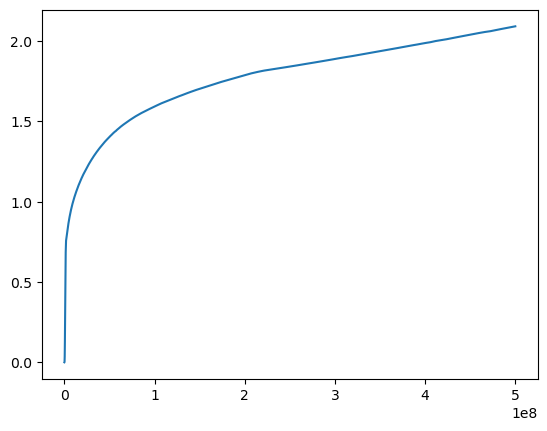

In [27]:
x = np.linspace(2e3, 0.5e9,10000)
y = fm(x)/2e33
plt.plot(x,y)

In [28]:
#turbulent dissipation. Ek=u'^3/L*Mg where u' is the turbulent velocity, L is the 
#largest eddy size (I usually take this to be a size of the gain region) 
#and Mg is the mass in the gain region.
def get_turbulent_dissipation(plt_file: str) -> np.ndarray:
    #here I wonder if we do not need to implment anything
    return 0

In [29]:
#Raynolds stress which is u'^2 averaged in the gain region. 
def get_raynolds_stress(plt_file: str) -> np.ndarray:
    
    ds = yt.load(plt_file)
    all_data = ds.all_data() #not sure this is needed, but I need units
    funcs = angle_average_profile(ds,1e3,1e9) #set rmax in a better way
    #For velx
    def _avvelx(field, data):
        return funcs['velx'](data['spherical_radius'])*data['velx'].units 

    ds.add_field(('gas', 'ave_velx'),
        function=_avvelx,
        sampling_type='cell',
        units=all_data['velx'].units,
        take_log=False,
        force_override=True)
    
    def _primvelx(field, data):
        return (data['velx'] - data['ave_velx'])

    ds.add_field(('gas', 'prime_velx'),
        function=_primvelx,
        sampling_type='cell',
        units=all_data['velx'].units,
        take_log=False,
        force_override=True)
    
    #For vely
    def _avvely(field, data):
        return funcs['vely'](data['spherical_radius'])*data['vely'].units 

    ds.add_field(('gas', 'ave_vely'),
        function=_avvely,
        sampling_type='cell',
        units=all_data['vely'].units,
        take_log=False,
        force_override=True)
    
    def _primvely(field, data):
        return (data['vely'] - data['ave_vely'])

    ds.add_field(('gas', 'prime_vely'),
        function=_primvely,
        sampling_type='cell',
        units=all_data['vely'].units,
        take_log=False,
        force_override=True)
    
    
    def _tau11(field, data):
        return data['prime_velx']**2
    def _tau22(field, data):
        return data['prime_vely']**2    
    def _tau12(field, data):
        return data['prime_velx']*data['prime_vely']  
    
    ds.add_field(('gas', 'tau11'),
        function=_tau11,
        sampling_type='cell',
        units=all_data['velx'].units*all_data['velx'].units,
        take_log=False,
        force_override=True)
    
    ds.add_field(('gas', 'tau22'),
        function=_tau22,
        sampling_type='cell',
        units=all_data['vely'].units*all_data['vely'].units,
        take_log=False,
        force_override=True)
        
    ds.add_field(('gas', 'tau12'),
        function=_tau12,
        sampling_type='cell',
        units=all_data['velx'].units*all_data['vely'].units,
        take_log=False,
        force_override=True)
    
    
    all_data = ds.all_data() #Feel like we need to redfine alldata now, maybe not
    prof = yt.Profile1D(all_data, ('spherical_radius'), 500, 1e3, 1e9, 
                        False, weight_field='cell_volume')
    prof.add_fields([('tau11')])
    prof.add_fields([('tau22')])
    prof.add_fields([('tau12')])
    
    return prof.x.v,prof['tau11'].v,prof['tau22'].v,prof['tau12'].v

In [30]:
#Raynolds stress which is u'^2 averaged in the gain region. 
#this calculation follows https://arxiv.org/pdf/1205.3491.pdf, see footnote 3.
def get_raynolds_stress_Murphy13(plt_file: str) -> np.ndarray:
    
    ds = yt.load(plt_file)
    all_data = ds.all_data() #not sure this is needed, but I need units
    funcs = angle_average_profile(ds,1e3,1e9) #set rmax in a better way
    #For velx
    def _avvelx(field, data):
        return funcs['velx'](data['spherical_radius'])*data['velx'].units 

    ds.add_field(('gas', 'ave_velx'),
        function=_avvelx,
        sampling_type='cell',
        units=all_data['velx'].units,
        take_log=False,
        force_override=True)
    
    def _primvelx(field, data):
        return (data['velx'] - data['ave_velx'])

    ds.add_field(('gas', 'prime_velx'),
        function=_primvelx,
        sampling_type='cell',
        units=all_data['velx'].units,
        take_log=False,
        force_override=True)
    
    #For vely
    def _avvely(field, data):
        return funcs['vely'](data['spherical_radius'])*data['vely'].units 

    ds.add_field(('gas', 'ave_vely'),
        function=_avvely,
        sampling_type='cell',
        units=all_data['vely'].units,
        take_log=False,
        force_override=True)
    
    def _primvely(field, data):
        return (data['vely'] - data['ave_vely'])

    ds.add_field(('gas', 'prime_vely'),
        function=_primvely,
        sampling_type='cell',
        units=all_data['vely'].units,
        take_log=False,
        force_override=True)
    
    
    def _tau11(field, data):
        return data['dens']*data['prime_velx']*data['velx']
    def _tau22(field, data):
        return data['dens']*data['prime_vely']*data['vely']   
    def _tau12(field, data):
        return data['dens']*data['prime_vely']*data['velx']   
    def _tau21(field, data):
        return data['dens']*data['prime_velx']*data['vely']
    
    ds.add_field(('gas', 'tau11'),
        function=_tau11,
        sampling_type='cell',
        units=all_data['velx'].units*all_data['velx'].units*all_data['dens'].units,
        take_log=False,
        force_override=True)
    
    ds.add_field(('gas', 'tau22'),
        function=_tau22,
        sampling_type='cell',
        units=all_data['vely'].units*all_data['vely'].units*all_data['dens'].units,
        take_log=False,
        force_override=True)
        
    ds.add_field(('gas', 'tau12'),
        function=_tau12,
        sampling_type='cell',
        units=all_data['velx'].units*all_data['vely'].units*all_data['dens'].units,
        take_log=False,
        force_override=True)
    
    ds.add_field(('gas', 'tau21'),
        function=_tau12,
        sampling_type='cell',
        units=all_data['velx'].units*all_data['vely'].units*all_data['dens'].units,
        take_log=False,
        force_override=True)
    
    all_data = ds.all_data() #Feel like we need to redfine alldata now, maybe not
    prof = yt.Profile1D(all_data, ('spherical_radius'), 500, 1e3, 1e9, 
                        True, weight_field='cell_volume')
    prof.add_fields([('tau11')])
    prof.add_fields([('tau22')])
    prof.add_fields([('tau12')])
    prof.add_fields([('tau21')])
    prof.add_fields([('dens')])
    
    r11 = prof['tau11'].v/prof['dens'].v
    r21 = prof['tau21'].v/prof['dens'].v
    r12 = prof['tau12'].v/prof['dens'].v
    r22 = prof['tau22'].v/prof['dens'].v
    return prof.x.v,r11,r22,r12,r21

In [62]:
#Raynolds stress which is u'^2 averaged in the gain region. 
#this calculation follows https://arxiv.org/pdf/1205.3491.pdf, see footnote 3.
def get_raynolds_stress_spherical_coorinates_Murphy13(plt_file: str,
                                                      npoints=1500, rmin=1e4, rmax=1e9,do_log=False) -> np.ndarray:
    
    ds = yt.load(plt_file)
    all_data = ds.all_data() #not sure this is needed, but I need units
    funcs = angle_average_profile(ds,rmin,rmax,quantities=['dens','vrad','vphi'],
                                  npoints=npoints) #set rmax in a better way
    #For vrad
    def _avvrad(field, data):
        return funcs['vrad'](data['spherical_radius'])*data['vrad'].units 

    ds.add_field(('gas', 'ave_vrad'),
        function=_avvrad,
        sampling_type='cell',
        units=all_data['vrad'].units,
        take_log=False,
        force_override=True)
    
    def _primvrad(field, data):
        return (data['vrad'] - data['ave_vrad'])

    ds.add_field(('gas', 'prime_vrad'),
        function=_primvrad,
        sampling_type='cell',
        units=all_data['vrad'].units,
        take_log=False,
        force_override=True)
    
    #For vphi
    def _avvphi(field, data):
        return funcs['vphi'](data['spherical_radius'])*data['vphi'].units 

    ds.add_field(('gas', 'ave_vphi'),
        function=_avvphi,
        sampling_type='cell',
        units=all_data['vphi'].units,
        take_log=False,
        force_override=True)
    
    def _primvphi(field, data):
        return (data['vphi'] - data['ave_vphi'])

    ds.add_field(('gas', 'prime_vphi'),
        function=_primvphi,
        sampling_type='cell',
        units=all_data['vphi'].units,
        take_log=False,
        force_override=True)
    
    
    def _tau11(field, data):
        return data['dens']*data['prime_vrad']*data['vrad']
    def _tau22(field, data):
        return data['dens']*data['prime_vphi']*data['vphi']   
    def _tau12(field, data):
        return data['dens']*data['prime_vphi']*data['vrad']   
    def _tau21(field, data):
        return data['dens']*data['prime_vrad']*data['vphi']
    
    ds.add_field(('gas', 'tau11'),
        function=_tau11,
        sampling_type='cell',
        units=all_data['vrad'].units*all_data['vrad'].units*all_data['dens'].units,
        take_log=False,
        force_override=True)
    
    ds.add_field(('gas', 'tau22'),
        function=_tau22,
        sampling_type='cell',
        units=all_data['vphi'].units*all_data['vphi'].units*all_data['dens'].units,
        take_log=False,
        force_override=True)
        
    ds.add_field(('gas', 'tau12'),
        function=_tau12,
        sampling_type='cell',
        units=all_data['vrad'].units*all_data['vphi'].units*all_data['dens'].units,
        take_log=False,
        force_override=True)
    
    ds.add_field(('gas', 'tau21'),
        function=_tau12,
        sampling_type='cell',
        units=all_data['vrad'].units*all_data['vphi'].units*all_data['dens'].units,
        take_log=False,
        force_override=True)
    
    all_data = ds.all_data() #Feel like we need to redfine alldata now, maybe not
    prof = yt.Profile1D(all_data, ('spherical_radius'), npoints, rmin, rmax, 
                        do_log, weight_field='cell_volume')
    prof.add_fields([('tau11')])
    prof.add_fields([('tau22')])
    prof.add_fields([('tau12')])
    prof.add_fields([('tau21')])
    prof.add_fields([('dens')])
    
    r11 = (prof['tau11']/prof['dens']).v
    r21 = (prof['tau21']/prof['dens']).v
    r12 = (prof['tau12']/prof['dens']).v
    r22 = (prof['tau22']/prof['dens']).v
    return prof.x.v,[r11,r22,r12,r21]

In [65]:
plt_files = !ls /proj/astro_extreme/olivera/EOS_GWs/simulations_oliver/s20_HR_0.95/output/s20_0.95_hdf5_plt_cnt_*

In [76]:
dat_file = '/proj/astro_extreme/olivera/EOS_GWs/simulations_oliver/s20_HR_0.95/100throwFEC.dat'
log_file = '/proj/astro_extreme/olivera/EOS_GWs/simulations_oliver/s20_HR_0.95/s20_0.95.log'
yt.set_log_level('ERROR') #YT talks to much
res = fec(2, dat_file,log_file, plt_files[1:]) #First plt filegives error, i think its because it is a forced one.

Progress: [####################] 100.00% - 0m 0s lefttime...
Loop completed!

FEC completed!


In [77]:
save_fec_as_hf5f(res,"FEC_s20_EOS095_full.h5")

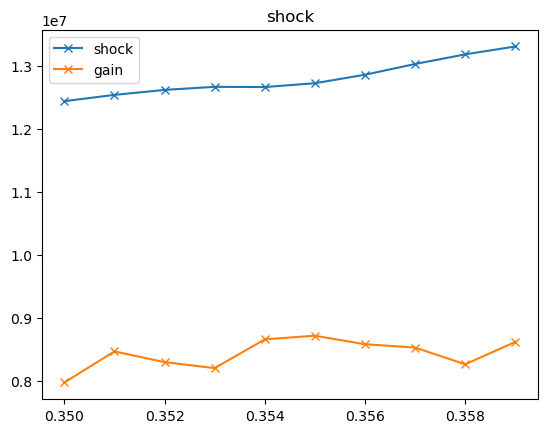

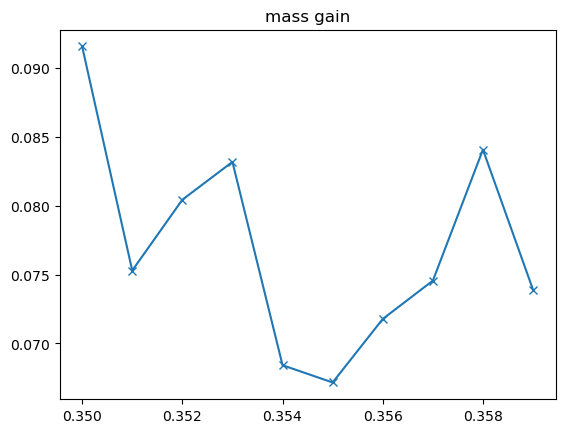

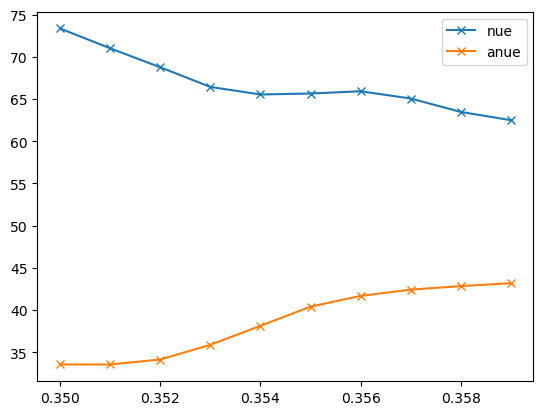

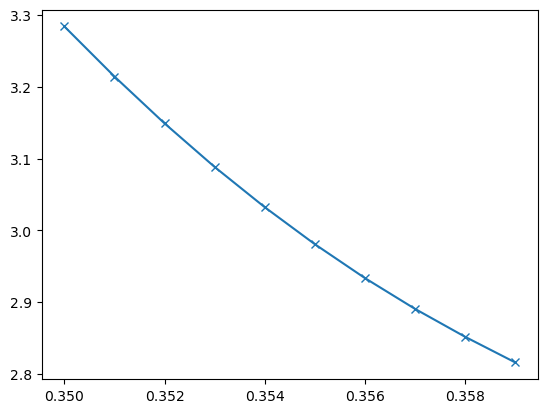

In [50]:
plt.plot(res['time'], res['shock_radius'], 'x-',label='shock')
plt.plot(res['time'], res['gain_radius'], 'x-',label='gain')
plt.title('shock')
plt.legend()
plt.show()
plt.plot(res['time'],np.array(res['mass_gainlayer'])/2e33,'x-')
plt.title('mass gain')
plt.show()
plt.plot(res['time'], res['lum_nue'], 'x-',label='nue')
plt.plot(res['time'], res['lum_anue'], 'x-',label='anue')
plt.legend()
plt.show()
plt.plot(res['time'], np.array(res['mass_accretion'])/2e33, 'x-')
plt.show()

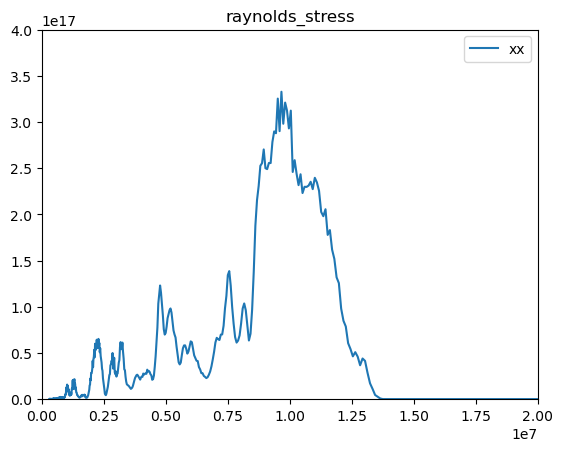

In [53]:
plt.plot(res['r'][1], res['raynolds_stress'][1][1], '-',label='xx')
plt.title('raynolds_stress')
plt.legend()
plt.xlim([0,2e7])
plt.ylim([0,4e17])
plt.show()

plt.show()

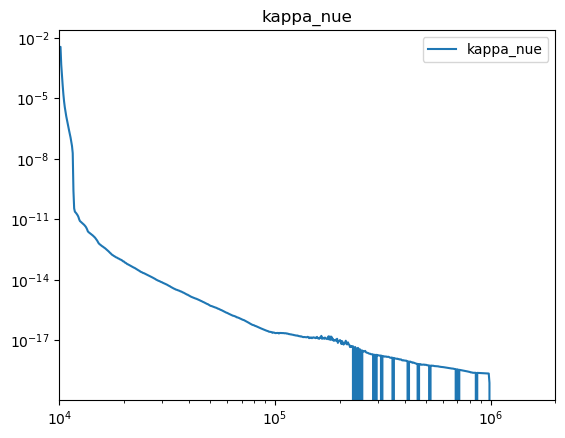

In [58]:
plt.plot(res['r'][1],res['kappa_nue'][1], '-',label='kappa_nue')
plt.title('kappa_nue')
plt.xlim([1e4,2e6])
#plt.ylim([0,1e17])
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()

plt.show()

In [137]:
print(res['kappa_nue'][0][1].max())
print(res['kappa_nue'][0][1].min())

0.4992043938113267
0.0


In [163]:
res['kappa_nue'][1][1]

array([0., 0., 0., ..., 0., 0., 0.])

In [2]:
import h5py

In [3]:
file = h5py.File('FEC_s20_EOS095_full.h5','r')

In [4]:
file.keys()

<KeysViewHDF5 ['bounce_time', 'gain_radius', 'heating', 'kappa_anue', 'kappa_nue', 'lum_anue', 'lum_nue', 'mass_accretion', 'mass_gainlayer', 'r', 'raynolds_stress', 'shock_radius', 'time']>

In [ ]:
keys = ['time', 'bounce_time', 'shock_radius', 'lum_nue', 'lum_anue', 'heating', 
        'mass_gainlayer', 'kappa_nue', 'kappa_anue', 'raynolds_stress', 'gain_radius', 'mass_accretion']
for key in keys:
    if 'kappa' in key:
        continue
    else:
        print(key, res[key])

In [ ]:
'kappa' in 'kappa_anue'

In [ ]:
10367201.697001794/1e5

In [66]:
plt_files

['/proj/astro_extreme/olivera/EOS_GWs/simulations_oliver/s20_HR_0.95/output/s20_0.95_hdf5_plt_cnt_0000',
 '/proj/astro_extreme/olivera/EOS_GWs/simulations_oliver/s20_HR_0.95/output/s20_0.95_hdf5_plt_cnt_0001',
 '/proj/astro_extreme/olivera/EOS_GWs/simulations_oliver/s20_HR_0.95/output/s20_0.95_hdf5_plt_cnt_0002',
 '/proj/astro_extreme/olivera/EOS_GWs/simulations_oliver/s20_HR_0.95/output/s20_0.95_hdf5_plt_cnt_0003',
 '/proj/astro_extreme/olivera/EOS_GWs/simulations_oliver/s20_HR_0.95/output/s20_0.95_hdf5_plt_cnt_0004',
 '/proj/astro_extreme/olivera/EOS_GWs/simulations_oliver/s20_HR_0.95/output/s20_0.95_hdf5_plt_cnt_0005',
 '/proj/astro_extreme/olivera/EOS_GWs/simulations_oliver/s20_HR_0.95/output/s20_0.95_hdf5_plt_cnt_0006',
 '/proj/astro_extreme/olivera/EOS_GWs/simulations_oliver/s20_HR_0.95/output/s20_0.95_hdf5_plt_cnt_0007',
 '/proj/astro_extreme/olivera/EOS_GWs/simulations_oliver/s20_HR_0.95/output/s20_0.95_hdf5_plt_cnt_0008',
 '/proj/astro_extreme/olivera/EOS_GWs/simulations_olive

In [ ]:
res.keys()

In [ ]:
res['kappa_anue']

In [ ]:
plt_files = !ls /proj/astro_extreme/olivera/EOS_GWs/simulations_oliver/s20_HR_0.95/output/s20_0.95_hdf5_plt_cnt_001*

In [ ]:
plt_files

In [ ]:
eosnr_to_eos(2)

In [ ]:
path = '/proj/astro_extreme/olivera/EOS_GWs/simulations_oliver/s20_HR_0.95/output'
fil = 's20_0.95_hdf5_plt_cnt_0382'
rr,tau11,tau22,tau12,tau21 = get_raynolds_stress_spherical_coorinates_Murphy13(f'{path}/{fil}')
#rrxy,tau11xy,tau22xy,tau12xy,tau21xy  = get_raynolds_stress_Murphy13(f'{path}/{fil}')

plt.plot(rr/1e5,tau22)
#plt.plot(rrxy/1e5,tau22xy)
plt.xlim(0,300)

In [ ]:
ds = yt.load(f'{path}/{fil}')
ray = ds.ray((0,0,0),(1e9,0,0))

f,ax = plt.subplots(figsize=(10,10/1.41),nrows=1,ncols=1,sharey='col',sharex='all')
ax.plot(ray['t']*1e4,ray['vrad'],lw=2)
ax.plot(ray['t']*1e4,ray['vphi'],lw=2)
ax.set_xlim([0,1500])
#ax.set_ylim([-8e18,4e16])
#ax.set_yscale('log')


In [ ]:
first_plt_file_PB55 = 320
last_plt_file55 = 1336
first_plt_file_PB75 = 320 #319 but gain radius not defined before 320
last_plt_file75 = 1299
first_plt_file_PB95 = 320
last_plt_file95 = 1175

In [ ]:
datfile55 = '/proj/astro_extreme/olivera/EOS_GWs/simulations_oliver/s20_HR_0.55/100throwFEC.dat'
datfile75 = '/proj/astro_extreme/olivera/EOS_GWs/simulations_oliver/s20_HR_0.75/100throwFEC.dat'
datfile95 = '/proj/astro_extreme/olivera/EOS_GWs/simulations_oliver/s20_HR_0.95/100throwFEC.dat'


logfile55 = '/proj/astro_extreme/olivera/EOS_GWs/simulations_oliver/s20_HR_0.55/s20_0.55.log'
logfile75 = '/proj/astro_extreme/olivera/EOS_GWs/simulations_oliver/s20_HR_0.75/s20_0.75.log'
logfile95 = '/proj/astro_extreme/olivera/EOS_GWs/simulations_oliver/s20_HR_0.95/s20_0.95.log'
tbounce55 = get_bounce_time(0);print(tbounce55)
tbounce75 = get_bounce_time(1);print(tbounce75)
tbounce95 = get_bounce_time(2);print(tbounce95)

In [ ]:
def dataframe(filename):
    df = pd.read_csv(filename, delim_whitespace=True, low_memory=False, skiprows=1,
    names=['time', 'mass', 'x-momentum', 'y-mom', 'z-mom', 'E_tot', 'E_kin', '8', 'E_grav',
           'E_expl', 'E_bind_gain', 'mean_shock_r', 'min_shock_r', 'accretion_rate', 'max_shock_r', 'magnetic_energy', 'central_density',
           'net_heating_rate', '19', 'avg_entropy_in_gain', 'M_NS', 'pns_rot', 'pns_x', 'pns_y', 'pns_z',
           'com-x', 'com-y', 'com-z', 'radius_pns_avg', 'correct_radius_pns', 'E_kin_theta', 'E_kin_phi_gain', '33', 'M1_lum_tot_nue', 'M1_lum_tot_anue', 
           'M1_lum_tot_nux', 'M1_aveE_nue', 'M1_aveE_anue', 'M1_aveE_nux', '40', '41', '42', 'R_nue', 'R_anue', 'R_nux',
           'dIxx1', 'dIxy1', 'dIyy1', '49', '50', '51', 'dIxx2', 'dIxy2', 'dIyy2', '55', '56', '57', 'dIxx3', 'dIxy3', 'dIyy3', '61', '62', '63'], )
    return df

In [ ]:
df55 = dataframe(datfile55)
df75 = dataframe(datfile75)
df95 = dataframe(datfile95)

# The test zone

In [ ]:
datfile = '/proj/astro_extreme/olivera/EOS_GWs/simulations_oliver/s20_HR_0.95/100throwFEC.dat'
dat_file = read_datfile(datfile)


In [ ]:
plt.plot(get_time(dat_file),get_correct_PNS_radius(dat_file)/1e5)
plt.plot(get_time(dat_file),get_average_PNS_radius(dat_file)/1e5)


In [ ]:
acc55all=np.loadtxt('accr_rate55all')
times55=np.loadtxt('times55')
acc55neg=np.loadtxt('accr_rate55neg')
plt.plot(times55,acc55all/cn.M_sun.cgs.value, 'x-', label='plt files')
plt.plot(times55,acc55neg/cn.M_sun.cgs.value, 'x-', label='plt files neg')
plt.plot(df55['time'], df55['accretion_rate']/cn.M_sun.cgs.value,label='dat file')
plt.xlim(0.4,1.5)
plt.ylim(0,2)
plt.legend()

In [ ]:
acc75all=np.loadtxt('accr_rate75all')
times75=np.loadtxt('times75')
acc75neg=np.loadtxt('accr_rate75neg')
plt.plot(times75,acc75all/cn.M_sun.cgs.value, '-', label='plt files')
plt.plot(times75,acc75neg/cn.M_sun.cgs.value, '-', label='plt files neg')
plt.plot(df75['time'], df75['accretion_rate']/cn.M_sun.cgs.value,label='dat file')
plt.xlim(0.4,1.4)
plt.ylim(0,2)
plt.legend()

In [ ]:
acc95all=np.loadtxt('accr_rate95all')
times95=np.loadtxt('times95')
acc95neg=np.loadtxt('accr_rate95neg')
plt.plot(times95,acc95all/cn.M_sun.cgs.value, '-', label='plt files')
plt.plot(times95,acc95neg/cn.M_sun.cgs.value, '-', label='plt files neg')
plt.plot(df95['time'], df95['accretion_rate']/cn.M_sun.cgs.value,label='dat file')
#plt.xlim(0.4,1.3)
plt.ylim(0,2)
plt.legend()

In [ ]:
from yt import derived_field
import matplotlib.pylab as plt

@derived_field(name="radius", sampling_type="cell", units="cm",force_override=True)
def _radius(field, data):
    return np.sqrt(data[('r')]**2 + data[('z')]**2 )

@derived_field(name="rhoprime", sampling_type="cell", units="cm",force_override=True)
def _rhoprime(field, data):
    from scipy import interpolate
    return np.sqrt(data[('r')]**2 + data[('z')]**2 )

In [ ]:
path = '/proj/astro_extreme/olivera/EOS_GWs/simulations_oliver/s20_HR_0.95/output'
fil = 's20_0.95_hdf5_plt_cnt_0382'
data = yt.load(f'{path}/{fil}')
all_data = data.all_data()

In [ ]:
funcs = angle_average_profile(data,1e4,1e9)

In [ ]:
def _avdens(field, data):
    return funcs['dens'](data['spherical_radius'])*data['dens'].units 

data.add_field(('gas', 'ave_dens'),
    function=_avdens,
    sampling_type='cell',
    units='auto',
    take_log=False,
    force_override=True)


In [ ]:
def _primedens(field, data):
    return (data['dens'] - data['ave_dens'])

data.add_field(('gas', 'prime_dens'),
    function=_primedens,
    sampling_type='cell',
    units='auto',
    take_log=False,
    force_override=True)

In [ ]:
all_data['prime_dens']

In [ ]:
lnames= ('abs','tsp')
lvalues = [1,2]
ldic = {}
ldic = {name: value for name, value in zip(lnames, lvalues)}

In [ ]:
ldic.keys()

In [ ]:
ldic['abs']

In [ ]:
path = '/proj/astro_extreme/olivera/EOS_GWs/simulations_oliver/s20_HR_0.75/output/s20_0.75_hdf5_plt_cnt_'
pltnr = str(500).zfill(4)
filename = path+pltnr
ds = yt.load(filename)
ad = ds.all_data()
time = ds.current_time.v - tbounce75
print(time)

In [ ]:
profile = yt.Profile1D(ad, ('spherical_radius'), 1000, 5e5, 300e5, True, weight_field='cell_volume')
profile.add_fields([('deps')])
profile.add_fields([('dens')])
profile.add_fields([('spherical_radius')])
plt.plot(profile.x.v, profile['deps'].v)

In [ ]:
profile = yt.Profile1D(ad, ('spherical_radius'), 1000, 5e5, 300e5, True, weight_field='cell_volume')
profile.add_fields([('deps')])
profile.add_fields([('dens')])
profile.add_fields([('spherical_radius')])
plt.plot(profile.x.v, profile['deps'].v)

In [ ]:
plt.plot(profile.x.v, profile['deps'].v)
minind = np.argmin(profile['deps'].v);

ind = np.where((profile['deps'].v[minind:] > 0.) )[0][0]

    
plt.axvline(profile.x.v[minind:][ind], ls=':', color='black')
gain_radius = profile.x.v[minind:][ind]
print(gain_radius/1e5)

In [ ]:
def get_gain_radius(eosnr:int, pltlimits:list):
    N = pltlimits[1]- pltlimits[0] + 1
    #gain_radius_list = np.zeros(N)
    #time_list = np.zeros(N)
    gain_radius_list = []
    time_list = []
    for i, pltfile in enumerate(range(pltlimits[0], pltlimits[1]+1)):
        pltnr = str(pltfile).zfill(4)
        print(pltnr)
        outputbase = get_outputbase(eosnr)
        filename = outputbase+pltnr
        ds = yt.load(filename)
        ad = ds.all_data()
        time = ds.current_time.v - tbounce75
        profile = yt.Profile1D(ad, ('spherical_radius'), 1000, 5e5, 300e5, True, weight_field=None)
        profile.add_fields([('deps')])
        minind = np.argmin(profile['deps'].v);
        try:
            ind = np.where((profile['deps'].v[minind:] > 0.) )[0][0]
        except:
            print('couldnt find a positive value after the global minimum')
            continue
        gain_radius = profile.x.v[minind:][ind]
        gain_radius_list.append(gain_radius)
        time_list.append(time)
    eos = eosnr_to_eos(eosnr)
    np.savetxt('./gain_radius{}.txt'.format(eos), gain_radius_list)
    np.savetxt('./gain_radius_times{}.txt'.format(eos), time_list)

In [ ]:
get_gain_radius(2, get_pltrange(2))

In [ ]:
gr75 = np.loadtxt('./gain_radius0.75.txt')
gr75t = np.loadtxt('./gain_radius_times0.75.txt')

plt.plot(gr75t, gr75, label='gain radius')
plt.plot(df75['time'] - tbounce75, df75['mean_shock_r'], label='shock radius')
plt.plot(df75['time'] - tbounce75, df75['correct_radius_pns'], label='pns radius')
plt.legend()
plt.show()

In [ ]:
np.where((profile['deps'].v > 0.) & (10e5 < profile.x.v) )


In [ ]:
eosnr=0
energy_bin=1
base = '/proj/astro_extreme/olivera/EOS_GWs/simulations_oliver/'
nulib_file = base + 'NuLib_SRO_{}.h5'.format(eosnr_to_eos(eosnr))
table = h5py.File(nulib_file,'r')

temps = table['temp_points'] # Mev
rhos = table['rho_points'] #cgs
yes = table['ye_points']

table_opacity_nue = table['absorption_opacity'][int(energy_bin),0,:,:,:]
mif_opacity_nue = rgi((yes,temps,rhos), table_opacity_nue)

In [ ]:
table['neutrino_energies'][:]

In [ ]:
energy_bins = range(0,12)
print('[', end='')
for i in energy_bins:
    if i < 11:
        print("'fopacity_nue{}', ".format(i+1), end='')
    if i == 11:
        print("'fopacity_nue{}'] ".format(i+1))
        
print('[', end='')
for i in energy_bins:
    if i < 11:
        print("'fopacity_anue{}', ".format(i+1), end='')
    if i == 11:
        print("'fopacity_anue{}'] ".format(i+1))

In [ ]:
opacity_nue_list = ['fopacity_nue1', 'fopacity_nue2', 'fopacity_nue3', 'fopacity_nue4', 'fopacity_nue5', 'fopacity_nue6', 'fopacity_nue7', 'fopacity_nue8', 'fopacity_nue9', 'fopacity_nue10', 'fopacity_nue11', 'fopacity_nue12']
opacity_anue_list = ['fopacity_anue1', 'fopacity_anue2', 'fopacity_anue3', 'fopacity_anue4', 'fopacity_anue5', 'fopacity_anue6', 'fopacity_anue7', 'fopacity_anue8', 'fopacity_anue9', 'fopacity_anue10', 'fopacity_anue11', 'fopacity_anue12'] 

globals()['fopacity_nue1'], globals()['fopacity_anue1'] = get_kappa_nu_interpolators(0,0)

In [198]:
 -2.14096882e+00+  2.17609126e+00

0.03512244000000031

In [197]:
-2.10584639e+00 + 2.14096882e+00

0.03512242999999993